# Milestone-2: Regression

This notebook corresponds to the second stage of the Machine Learning final project, as part of the Copernicus Master in Digital Earth, in the Data Science track at UBS by Candela Sol PELLIZA & Rajeswari PARASA.

The project is focused on properties' price prediction for the city of Ames, Iowa, Us. The present Notebook contains two parts: 
1. The first part corresponds to some updates and corrections in the preprocessing and splitting of data that was proposed in the previous stage, ending with the updated, ready-to-work training and test sets.
2. The second part corresponds to the specific tasks of regression, following the requirements of milestone 2

## PART 1: UPDATES ON PREPROCESSING STEPS FROM MILESTONE 1

The observations we got from the milestone-1 notebook, mainly regarding the splitting of data and some minor preprocessing steps, made us consider that we needed to change the way we were splitting the data into train and test. Considering that this step was performed at the very beginning of the previous notebook, with the purpose of avoiding data leakage in the preprocessing, redoing the train-test split implies also redoing the preprocessing steps.

Having this situation in mind, this first part of the notebook will present in detail the new changes we decided to include, in terms of both data splitting and preprocessing. However, for the rest of preprocessing steps, as they were already explained and justified in the previous notebook, they will be added here to include the whole workflow, but not explained again.

### 1.a. Loading libraries and importing the original dataset

In [2]:
#Importing Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [3]:
#Setting pandas to show all the columns
pd.set_option('display.max_columns', None)

In [5]:
#Importing  and visualizing the dataset
data = pd.read_csv('OpenData/Ames.csv')
data.head()

,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,Lot.Shape,Land.Contour,Utilities,Lot.Config,Land.Slope,Neighborhood,Condition.1,Condition.2,Bldg.Type,House.Style,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Roof.Style,Roof.Matl,Exterior.1st,Exterior.2nd,Mas.Vnr.Type,Mas.Vnr.Area,Exter.Qual,Exter.Cond,Foundation,Bsmt.Qual,Bsmt.Cond,Bsmt.Exposure,BsmtFin.Type.1,BsmtFin.SF.1,BsmtFin.Type.2,BsmtFin.SF.2,Bsmt.Unf.SF,Total.Bsmt.SF,Heating,Heating.QC,Central.Air,Electrical,X1st.Flr.SF,X2nd.Flr.SF,Low.Qual.Fin.SF,Bsmt.Full.Bath,Bsmt.Half.Bath,Full.Bath,Half.Bath,Bedroom.AbvGr,Kitchen.AbvGr,Kitchen.Qual,TotRms.AbvGrd,Functional,Fireplaces,Fireplace.Qu,Garage.Type,Garage.Yr.Blt,Garage.Finish,Garage.Cars,Garage.Area,Garage.Qual,Garage.Cond,Paved.Drive,Wood.Deck.SF,Open.Porch.SF,Enclosed.Porch,X3Ssn.Porch,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,GasA,Fa,Y,SBrkr,1656,0,0,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2.0,528.0,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,GasA,Ex,Y,SBrkr,2110,0,0,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2.0,522.0,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


### 1.b. First preprocessing steps

In [6]:
#Create a dictionary with the old and new variable's names
RenameMapping = {
    'area': 'BldgArea',
    'price': 'SoldPrice',
    'MS.SubClass': 'MSSubClass',
    'MS.Zoning': 'MSZoning',
    'Lot.Frontage': 'LotFrontage',
    'Lot.Area': 'LotArea',
    'Lot.Shape': 'LotShape',
    'Land.Contour': 'LandContour',
    'Lot.Config': 'LotConfig',
    'Land.Slope': 'LandSlope',
    'Condition.1': 'Condition1',
    'Condition.2': 'Condition2',
    'Bldg.Type': 'BldgType',
    'House.Style': 'HouseStyle',
    'Overall.Qual': 'OverallQual',
    'Overall.Cond': 'OverallCond',
    'Year.Built': 'YearBuilt',
    'Year.Remod.Add': 'YearRemodAdd',
    'Roof.Style': 'RoofStyle',
    'Roof.Matl': 'RoofMatl',
    'Exterior.1st': 'Exterior1st',
    'Exterior.2nd': 'Exterior2nd',
    'Mas.Vnr.Type': 'MasVnrType',
    'Mas.Vnr.Area': 'MasVnrArea',
    'Exter.Qual': 'ExterQual',
    'Exter.Cond': 'ExterCond',
    'Bsmt.Qual': 'BsmtQual',
    'Bsmt.Cond': 'BsmtCond',
    'Bsmt.Exposure': 'BsmtExposure',
    'BsmtFin.Type.1': 'BsmtFinType1',
    'BsmtFin.SF.1': 'BsmtFinSF1',
    'BsmtFin.Type.2': 'BsmtFinType2',
    'BsmtFin.SF.2': 'BsmtFinSF2',
    'Bsmt.Unf.SF': 'BsmtUnfSF',
    'Total.Bsmt.SF': 'TotalBsmtSF',
    'Heating.QC': 'HeatingQual',
    'Central.Air': 'CentralAir',
    '1st.Flr.SF': '1stFlrSF',
    '2nd.Flr.SF': '2ndFlrSF',
    'Low.Qual.Fin.SF': 'LowQualFinSF',
    'Bsmt.Full.Bath': 'BsmtFullBath',
    'Bsmt.Half.Bath': 'BsmtHalfBath',
    'Full.Bath': 'FullBath',
    'Half.Bath': 'HalfBath',
    'Kitchen.Qual': 'KitchenQual',
    'TotRms.AbvGrd': 'TotRmsAbvGrd',
    'Fireplaces': 'Fireplaces',
    'Fireplace.Qu': 'FireplaceQu',
    'Garage.Type': 'GarageType',
    'Garage.Yr.Blt': 'GarageYrBlt',
    'Garage.Finish': 'GarageFinish',
    'Garage.Cars': 'GarageCars',
    'Garage.Area': 'GarageArea',
    'Garage.Qual': 'GarageQual',
    'Garage.Cond': 'GarageCond',
    'Paved.Drive': 'PavedDrive',
    'Wood.Deck.SF': 'WoodDeckSF',
    'Open.Porch.SF': 'OpenPorchSF',
    'Enclosed.Porch': 'EnclosedPorchSF',
    '3Ssn.Porch': '3SsnPorchSF',
    'Screen.Porch': 'ScreenPorchSF',
    'Pool.Area': 'PoolArea',
    'Pool.QC': 'PoolQual',
    'Misc.Feature': 'MiscFeature',
    'Misc.Val': 'MiscVal',
    'Mo.Sold': 'MoSold',
    'Yr.Sold': 'YrSold',
    'Sale.Type': 'SaleType', 
    'Sale.Condition': 'SaleCondition',
    'X1st.Flr.SF': 'X1FloorSF',
    'X2nd.Flr.SF': 'X2FloorSF',
    'X3Ssn.Porch': '3SsnPorchSF',
    'Kitchen.AbvGr': 'KitchenAbvGr',
    'Bedroom.AbvGr': 'BedroomAbvGr',
    }

#Applying the name change
data.rename(columns=RenameMapping, inplace=True)

#Dropping 'Order' column
data = data.drop('Order', axis=1)

### 1.c. Data Split into Train and Test

After reviewing the train & test data split performed in milestone 1, we realised that the unbalanced spatial distribution of samples had not been taken into account properly. The spatial attribute of our data is given by the "neighborhood" variable.
The barplot below shows the amount of samples belonging to each neighborhood in the original dataset.

<Axes: xlabel='Neighborhood'>

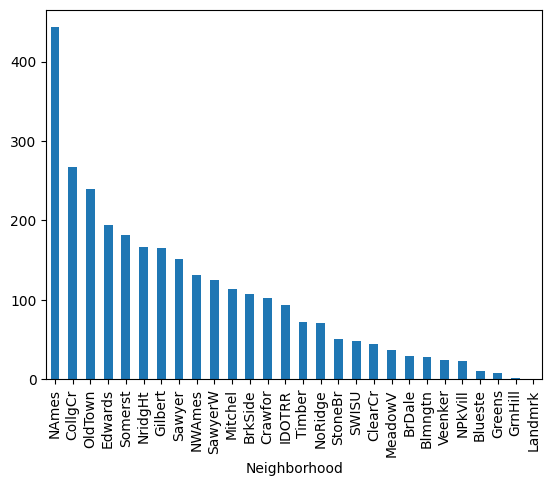

In [42]:
data['Neighborhood'].value_counts().plot(kind='bar')

The barplot gives meaningful information about two things. The first one is that the neighborhoods "GrnHill" and "Landmrk" have very few samples (1 and 2 respectively). The second one is that the neighborhoods' samples distribution is clearly unbalanced.

To solve the first issue, the rows corresponding to the mentioned neighborhoods will be dropped, given that such a small number can not be representative.

In [7]:
# Counting the number of samples
landmrk_smp = len(data[data['Neighborhood'] == 'Landmrk'])
print(f'Landmrk samples: {landmrk_smp}')

GrnHill_smp = len(data[data['Neighborhood'] == 'GrnHill'])
print(f'GrnHill samples: {GrnHill_smp}')

Landmrk samples: 1
GrnHill samples: 2


In [8]:
# Dropping the lines for Landmrk and GrnHill neighborhoods
neighb_todrop = ['Landmrk', 'GrnHill']
data = data[~data['Neighborhood'].isin(neighb_todrop)]

The next step is to handle the unbalanced neighborhoods' samples sdistribution. Considering that location is a key aspect on defining the price of a property, and taking into account the spatial autocorrelation effect, it is crucial to have a balanced distribution of samples from the different neighborhoods in our training and test datasets. This is specially important for the generalization of the model to unseen data, and also to take into account the influence of the spatial aspect.

When checking how the random split used in the previous notebook was handling this issue, we realised that the distribution was not balanced, specially for the classes with few samples. This can be confirmed in the graph below, which shows the neighborhood samples distribution in training and test dataset for the random technique previously adopted

In [9]:
#Divide data into train and test following the previously adopted technique
data_train_prev, data_test_prev = train_test_split(data, test_size=0.2, random_state=33)

# We use test_size =0.2 to indicate 20% of the data is used for testing and 80% for training
# We use random_state = 33 to ensure that the same random split is reproduced every time

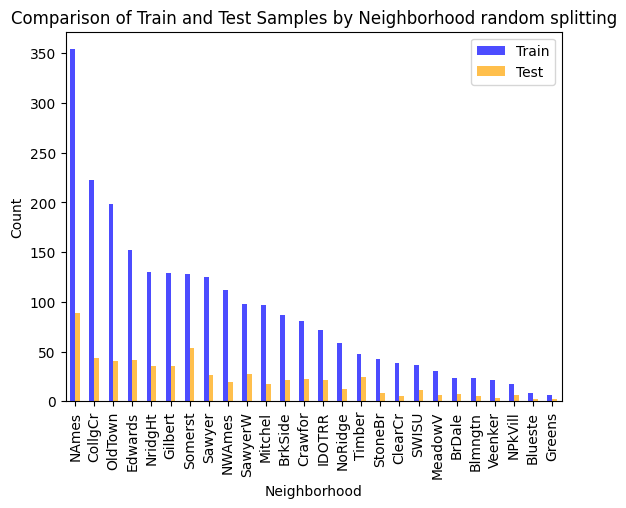

----------Proportions of samples from neighborhoods---------
   Neighborhood  train_prop %  test_prop %
0         NAmes          15.1         15.2
1       CollgCr           9.5          7.5
2       OldTown           8.5          7.0
3       Edwards           6.5          7.2
4       NridgHt           5.6          6.1
5       Gilbert           5.5          6.1
6       Somerst           5.5          9.2
7        Sawyer           5.3          4.4
8        NWAmes           4.8          3.2
9       SawyerW           4.2          4.6
10      Mitchel           4.1          2.9
11      BrkSide           3.7          3.6
12      Crawfor           3.5          3.8
13       IDOTRR           3.1          3.6
14      NoRidge           2.5          2.0
15       Timber           2.1          4.1
16      StoneBr           1.8          1.4
17      ClearCr           1.7          0.9
18        SWISU           1.6          1.9
19      MeadowV           1.3          1.0
20       BrDale           1.0       

In [46]:
# Function to plot double bar graphs to compare the distribution of neighborhoods in train and test sets
def samples_neighb(data_train, data_test, technique):
    # Count samples by neighborhood in train and test sets
    train_counts = data_train['Neighborhood'].value_counts().reset_index()
    test_counts = data_test['Neighborhood'].value_counts().reset_index()

    # Merge the counts based on the 'Neighborhood' column
    combined_counts = pd.merge(train_counts, test_counts, on='Neighborhood', how='outer')

    # Plot
    ax=combined_counts.plot(x='Neighborhood', kind='bar', color=['blue', 'orange'], alpha=0.7)
    plt.xlabel('Neighborhood')
    plt.ylabel('Count')
    plt.title(f'Comparison of Train and Test Samples by Neighborhood {technique} splitting')
    plt.legend(["Train", "Test"])
    plt.show()

    # Propotions as percentages
    combined_counts['train_prop %'] = round(combined_counts['count_x'] *100/ combined_counts['count_x'].sum(),1)
    combined_counts['test_prop %'] = round(combined_counts['count_y']*100 / combined_counts['count_y'].sum(),1)
    print('----------Proportions of samples from neighborhoods---------')
    print(combined_counts[['Neighborhood', 'train_prop %', 'test_prop %']])


samples_neighb(data_train_prev, data_test_prev, technique='random')

To guarantee a balanced distribution of neighborhoods' samples between training and test datasets, we will perform an stratified split for the neighborhood variable, by means of the "stratify" parameter in the scikitlearn train_test_split() function.

In [10]:
# Divide data into train and test with stratified split
data_train, data_test= train_test_split(data, test_size=0.2, random_state=33, stratify=data['Neighborhood'])

The plot below shows the distribution of neighborhoods' samples in training and test data after the stratified split, with a proportional amount of samples for each neighborhood.

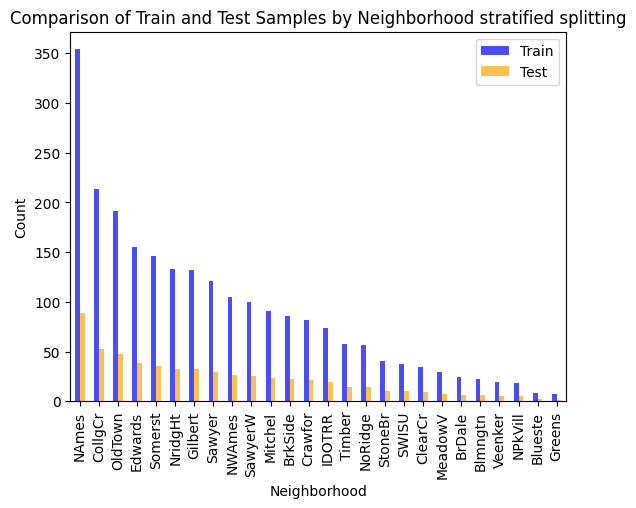

----------Proportions of samples from neighborhoods---------
   Neighborhood  train_prop %  test_prop %
0         NAmes          15.1         15.2
1       CollgCr           9.1          9.0
2       OldTown           8.2          8.2
3       Edwards           6.6          6.7
4       Somerst           6.2          6.1
5       NridgHt           5.7          5.6
6       Gilbert           5.6          5.6
7        Sawyer           5.2          5.1
8        NWAmes           4.5          4.4
9       SawyerW           4.3          4.3
10      Mitchel           3.9          3.9
11      BrkSide           3.7          3.8
12      Crawfor           3.5          3.6
13       IDOTRR           3.2          3.2
14       Timber           2.5          2.4
15      NoRidge           2.4          2.4
16      StoneBr           1.8          1.7
17        SWISU           1.6          1.7
18      ClearCr           1.5          1.5
19      MeadowV           1.3          1.2
20       BrDale           1.0       

In [48]:
samples_neighb(data_train, data_test, technique='stratified')

### 1.d. Post data-splitting Preprocessing

The following blocks of code contain all the preprocessing steps that the dataset requires, such as variables encoding and NA values handling, which were described in detail in the Milestone-1 notebook. For more information on the reasons, steps and parameters, refer to this notebook [## COMPLETE]

#### 1.d.1. Variables Encoding

In [11]:
ordinal = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQual', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQual', 'Fence', 'PavedDrive' ]
binary = ['Street', 'CentralAir']
nominal = ['MSSubClass', 'MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']
other = ['Alley']

Encoding Ordinal variables

In [50]:
# Mapping dictionary
variable_mappings = {
    'LotShape': {'Reg': 4, 'IR1': 3, 'IR2': 2, 'IR3': 1},
    'Utilities': {'AllPub': 4, 'NoSewr': 3, 'NoSeWa': 2, 'ELO': 1},
    'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
    'ExterQual': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'ExterCond': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtQual': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtCond': {'Ex': 6, 'Gd': 5, 'Ta': 4, 'Fa': 3, 'Po': 1, 'NA': 0},
    'BsmtExposure': {'Ex': 5, 'Gd': 4, 'Ta': 3, 'Fa': 2, 'Po': 1},
    'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'Lwq': 2, 'Unf': 1, 'Na': 0},
    'HeatingQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'KitchenQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
    'Functional': {'Typ': 8, 'Min1': 7, 'Min2': 6, 'Mod': 5, 'Maj1': 4, 'Maj2': 3, 'Sev': 2, 'Sal': 1},
    'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, 'NA': 0},
    'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0},
    'PoolQual': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, 'Na': 0},
    'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'NA': 0},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2}
}

# List of columns to map
columns_to_map = variable_mappings.keys()

def apply_mappings(data):
    for column in columns_to_map:
        data[column] = data[column].map(variable_mappings[column])

# Applying changes to training dataset
apply_mappings(data_train)

# Applying changes to test dataset
apply_mappings(data_test)

In [51]:
# Iterate through the columns in the 'ordinal' list and fill NA values with 0

#Applying changes to training dataset
for column in ordinal:
    data_train[column].fillna(0, inplace=True)

#Applying changes to test dataset
for column in ordinal:
    data_test[column].fillna(0, inplace=True)

Encoding binary variables

In [52]:
#Convert binary variables into numerical

Street = {'Grvl': 0, 'Pave': 1}
CentralAir = {'N': 0, 'Y': 1}

#Applying changes to training dataset
data_train['Street'] = data_train['Street'].map(Street)
data_train['CentralAir'] = data_train['CentralAir'].map(CentralAir)

#Applying changes to test dataset

data_test['Street'] = data_test['Street'].map(Street)
data_test['CentralAir'] = data_test['CentralAir'].map(CentralAir)

In [53]:
#Encode
Alley = {'Grvl': 1, 'Pave': 1, 'NA': 0}

#Applying changes to training dataset

data_train['Alley'] = data_train['Alley'].map(Alley)

#Fill NA
data_train['Alley'].fillna(0, inplace=True)

#Applying changes to test dataset

data_test['Alley'] = data_test['Alley'].map(Alley)

#Fill NA
data_test['Alley'].fillna(0, inplace=True)

#### 1.d.2. Handling NA Values

In [54]:
#Filling NAs on training
data_train['MiscFeature'].fillna('None', inplace=True)
data_train['GarageType'].fillna('None', inplace=True)

#Filling NAs on test
data_test['MiscFeature'].fillna('None', inplace=True)
data_test['GarageType'].fillna('None', inplace=True)

In [55]:
# Drop rows with NaN values in specific columns in training
columns_to_check = ['MasVnrType' , 'BsmtHalfBath', 'BsmtFullBath', 'GarageCars', 'Electrical', 'GarageArea']
data_train.dropna(subset=columns_to_check, inplace=True)

# Drop rows with NaN values in specific columns in test
data_test.dropna(subset=columns_to_check, inplace=True)

In [56]:
## LotFrontage VARIABLE

#Fill Na values with column mean - training
mean_LotFrontage_train = data_train['LotFrontage'].mean()
data_train['LotFrontage'].fillna(mean_LotFrontage_train, inplace=True)

#Fill Na values with column mean - test
mean_LotFrontage_test = data_test['LotFrontage'].mean()
data_test['LotFrontage'].fillna(mean_LotFrontage_test, inplace=True)

In [57]:
## GarageYrBlt VARIABLE

#Filling GarageYrBlt NA values with YearBuilt in training
data_train['GarageYrBlt'].fillna(data_train['YearBuilt'], inplace=True)

#Filling GarageYrBlt NA values with YearBuilt in test
data_test['GarageYrBlt'].fillna(data_test['YearBuilt'], inplace=True)


#### 1.d.3. Encoding Categorical Variables

In [58]:
# Perform one-hot encoding (returns True/False values) in training
data_train = pd.get_dummies(data_train, columns=nominal, prefix=nominal, dtype=int)

# Perform one-hot encoding (returns True/False values) in test
data_test = pd.get_dummies(data_test, columns=nominal, prefix=nominal, dtype=int)

### 1.e. Columns dropping

In the previous milestone, we observed that, the correlation matrix has two rows with `nan` values for all cells. Upon inspection of the corresponding features, we realised that the issue was cause because the columns had same value for all samples (because of being columns deried from onehot encoding). This columns are insignificant for the analysis, so we decide to drop them from both the training and test datasets.

In [59]:
# List of colunmns with only 1 value for all rows in test
def singlevalue_columns(data):
    # Create a list of single-valued columns
    singlevalue_cols = []
    for i in data.columns:
        if data[i].nunique() <2:
            singlevalue_cols.append(i)
    #print(f'Columns with only 1 value: {singlevalue_cols}')
    return singlevalue_cols

drop_cols = singlevalue_columns(data_train)
print(drop_cols)

['LowQualFinSF']


In [60]:
# Dropping columns in train dataset
data_train.drop(drop_cols, axis=1, inplace=True)

# Dropping columns in test dataset
data_test.drop(drop_cols, axis=1, inplace=True)

### 1.f. Treatment for missing columns between train and test

We are finished with column preprocessing at this stage for both train and test datasets. Since preprocessing is carried out separately for train and test datasets, we need to check if the number of columns match. This is important for being able to apply our train model to the test dataset afterwards.

In [61]:
# Columns missing in train data
missing_cols_tr =  set(data_test.columns) - set(data_train.columns)
print(len(missing_cols_tr), ' features from test data do not appear in train data')
print('These are ', missing_cols_tr)

7  features from test data do not appear in train data
These are  {'SaleType_ConLw', 'MiscFeature_TenC', 'SaleType_Con', 'Condition2_RRAn', 'Heating_Wall', 'RoofMatl_ClyTile', 'MiscFeature_Othr'}


In [62]:
# Columns missing in test data
missing_cols_te =  set(data_train.columns) - set(data_test.columns)
print(len(missing_cols_te), ' features from train data do not appear in test data')
print('These are ', missing_cols_te)

26  features from train data do not appear in test data
These are  {'MSSubClass_70', 'Condition2_PosA', 'MSSubClass_75', 'SaleCondition_AdjLand', 'Exterior2nd_ImStucc', 'MasVnrType_CBlock', 'RoofStyle_Gambrel', 'SaleType_Oth', 'Condition2_PosN', 'BldgType_2fmCon', 'RoofMatl_WdShngl', 'RoofStyle_Shed', 'Foundation_Wood', 'Condition1_RRNn', 'Condition2_Feedr', 'MiscFeature_Elev', 'Neighborhood_MeadowV', 'LotConfig_FR3', 'HouseStyle_2.5Unf', 'RoofMatl_Roll', 'MSSubClass_190', 'Exterior1st_BrkFace', 'Exterior2nd_Other', 'SaleType_VWD', 'Condition1_RRAe', 'SaleType_ConLI'}


We can see that the columns in the dataset are not matching, having each dataset some columns that are no present on the other one. Following a procedure that avoids data leakage, we need to consider as valid all, and only, the columns that are present in our train dataset after the preprocessing. 

This means that we will perform a two step procedure:

The columns that are present in the test dataset but not in the train set will be eliminated from the test set. This is beause the test set is considered as unseen data, for which we shouldnt have knowledge about this other variables existence.

For the columns that are present in the training dataset but not in the test one, we will recreate them in the test dataset, at the same position, filling all the rows with zeros. The addition of these columns will be neutral in affecting the test dataset, but will make it easier for handling numpy arrays with the same dimensions.

In [63]:
# Treatment for missing columns:

# A) For columns missing in train data, drop them from test data. 

data_test.drop(missing_cols_tr, axis=1, inplace=True)

# B) For columns missing in test data, add them to test data and fill them with 0s.
for c in missing_cols_te:
    data_test[c] = 0
print(data_test.shape)

(231, 204)


In [64]:
data_train.shape

(923, 204)

The columns in both train and test datasets, now match. We are now ready to export them to csv files for further analysis in the next milestone.

### 1.g. Processed datasets exporting
After processing both training and test datasets, we export them as csv files. It is improtant to notice that the normalization step that will be performed later should also be done for the testing set when running the models.


In [65]:
# Exporting training datset
data_train.to_csv('OpenData/ames_train_clean.csv', index=False)

# Exporting test datset
data_test.to_csv('OpenData/ames_test_clean.csv', index=False)

### 1.h. Target Variable Distribution, Outliers and Evaluation Metric

During the exploatory analysis of the data performed in the previous notebok, we identify two main issues in the distribution of our data:

1- **The target variable is right skewed and not normally distributed. This can be seen in the histogram plot and the QQ plot below.**

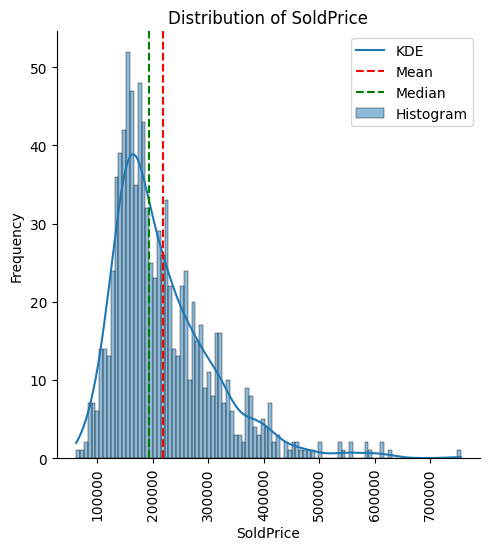 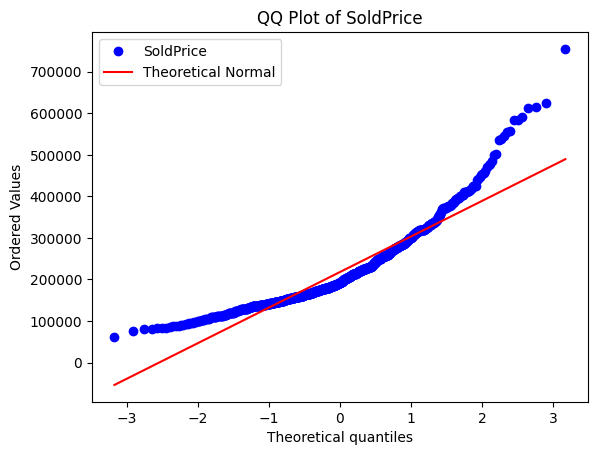

2- **There are outliers in the data (as can be seen in the graph below plotted between SoldPrice and BldgArea.)** 

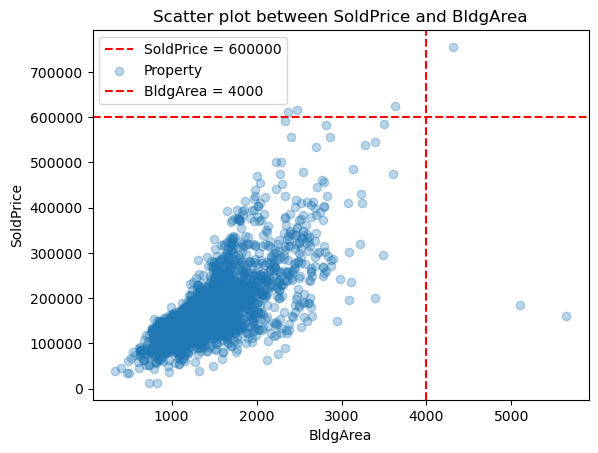

Due to these characteristics, we discussed in the previous notebook the possbility of log transforming the data, and eliminating the outliers, for obtaining a normally distributed dataset. However, after reconciling our observations from the EDA and the feedback received from the mentors, we realised that doing these steps were redundant with the proposition of RMSLE as the main metric.

Based on literature that we encountered on the RMSLE metric, is robust to outliers ([Saxena, 2019](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a); [Sagi, 2023](https://help.pecan.ai/en/articles/6456388-model-performance-metrics-for-regression-models#Modelperformancemetricsforregressionmodels-RootMeanSquaredLogarithmicError(RMSLE))) and is suitable for non-normally distributed or skewed data [(Hussain, 2022)](https://techwithshadab.medium.com/root-mean-squared-error-root-mean-squared-logarithmic-error-70e645efcccb). This is because RMSLE measures the relative distance of the predicted value from the actual value, unlike RMSE which measures the absolute distance. Due to this, RMSE can be heavily affected by the outliers, the range of the target variable and the distribution of the target variable.

Following this criteria, the dataset will be kept without dropping any outlier or applying log transformation, considering these characteristics when measuring the model accuracy with RMSLE.

Moreover, we will keep taking into account the other two auxiliary metrics previously defined:

- RSME given that it provides a good measure of how far the predicted values are from the groundtruth values, providing the error value in the same unit scale as the target variable. Being our prediction in a currency unit, this allows an easy interpretability of the results. 

- R2 in order to allow for a standardised comparison. It gives a measure of how much of the variance in the data is explained by the model, and allows comparing the results with other models in a range from 0-1. 

## 2. MILESTONE 2: REGRESSION

### 2.a. Importing data and transforming to Numpy Array

In [48]:
# Import train and test datasets in csv format
data_train = pd.read_csv('OpenData/ames_train_clean.csv')
data_test = pd.read_csv('OpenData/ames_test_clean.csv')

In [49]:
data_train.shape

(923, 204)

In [50]:
data_test.shape

(231, 204)

After importing the datasets in csv format, we transform them to numpy array format. We will also store the names of the columns in a separate vector

In [54]:
# Creating numpy arrays for X and Y
X_train = data_train.drop(columns = ['PID', 'SoldPrice']).values
X_test = data_test.drop(columns = ['PID', 'SoldPrice']).values
X_names = data_train.columns.tolist()

Y_train = data_train['SoldPrice'].values.reshape(-1,1)
Y_test = data_test['SoldPrice'].values.reshape(-1,1)

In [53]:
print(X_names)

['PID', 'BldgArea', 'SoldPrice', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQual', 'CentralAir', 'X1FloorSF', 'X2FloorSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorchSF', '3SsnPorchSF', 'ScreenPorchSF', 'PoolArea', 'PoolQual', 'Fence', 'MiscVal', 'MoSold', 'YrSold', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90', 'MSSubClass_120', 'MSSubClass_160', 'MSSub

In [21]:
X_train

array([[2.5190e+03, 4.2000e+01, 2.6178e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [1.7280e+03, 9.8000e+01, 1.3260e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0980e+03, 7.4000e+01, 7.3900e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       ...,
       [2.3380e+03, 5.2000e+01, 5.1974e+04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [1.0730e+03, 7.4000e+01, 9.9810e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.8140e+03, 7.4000e+01, 9.7710e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [16]:
X_test

array([[ 1524.        ,    75.95628415,  2998.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 2020.        ,    94.        , 12220.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 1960.        ,    95.        , 13618.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [ 1494.        ,    39.        , 15410.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 2198.        ,    84.        , 14260.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 1726.        ,    79.        ,  9416.        , ...,
            0.        ,     0.        ,     0.        ]])

In [55]:
Y_train

array([[335000],
       [ 84900],
       [135000],
       [110000],
       [159900],
       [230000],
       [145000],
       [188000],
       [300000],
       [113500],
       [294900],
       [209500],
       [341000],
       [279000],
       [394617],
       [184900],
       [535000],
       [237000],
       [133000],
       [192500],
       [144500],
       [140000],
       [148000],
       [225000],
       [173000],
       [190000],
       [100000],
       [160000],
       [203135],
       [409900],
       [392000],
       [195000],
       [250000],
       [293000],
       [248900],
       [124500],
       [206000],
       [312500],
       [245000],
       [226500],
       [229000],
       [120000],
       [221000],
       [187500],
       [293077],
       [143000],
       [221800],
       [378000],
       [152000],
       [339750],
       [145500],
       [147000],
       [215000],
       [145500],
       [258000],
       [132000],
       [177000],
       [611657],
       [285000

### 2.a. Standardization
As we concluded in the visual analysis from the previous notebook, the variables have different scales. This can be a problem for linear regression, as the variables with higher scale will have a higher impact on the model. To avoid this problem, we will standardize the variables. This will bring all the variables to the same scale, and hence the variables will have equal impact on the model.

We now create a function that standardises the variables using mean centring and scaling.

## CHECK:
Explain here the issue of the division by std=0, and why we are choosing to handle this issue in the test dataset by assigning an std of 1

#### Standardisation (method 1 - using inbuilt function)

In [56]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

# Stack ones to X matrices to account for the intercept
X_train = np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test))

In [27]:
X_train

array([[ 1.        ,  1.62061741, -1.48895632, ..., -0.11952286,
         0.49220027, -0.37538608],
       [ 1.        ,  0.11620038,  1.11671724, ..., -0.11952286,
        -2.03169333, -0.37538608],
       [ 1.        , -1.08200787,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608],
       ...,
       [ 1.        ,  1.27637028, -1.02365747, ..., -0.11952286,
        -2.03169333,  2.66392403],
       [ 1.        , -1.12955582,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608],
       [ 1.        ,  2.18168318,  0.        , ..., -0.11952286,
         0.49220027, -0.37538608]])

In [28]:
X_test

array([[ 1.00000000e+00, -2.40384636e-01, -5.48281015e-16, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  6.82831603e-01,  6.96159874e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  5.71152219e-01,  7.34741721e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.00000000e+00, -2.96224328e-01, -1.42584168e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.01414711e+00,  3.10341410e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.35602623e-01,  1.17432177e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

#### 2. Selection of regression model

Based on the exploratory data analysis performed in the previous milestone, we will begin with fitting a multivariate linear regression model to our data and understand its performance. Since we observe notable values for Pearson's correlation coefficient between the target variable and the features, we expect the linear regression model to be a good model to start with for establishing a multivariate relationship between the them. 

However, we do bear in mind that a linear regression model is sensitive to outliers and skewness of the target variable (which have not been treated with log transformation currently). 

#### 3. Multivariate Linear Regression

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from math import sqrt

We define a function... (explain)

In [34]:
# Defining functions to plot the predictions and to print error metrics
# def model_pred(x,y, xtest, ytest):       
#     # Fit the model
#     model = LinearRegression().fit(x,y)
#     # Predict
#     y_pred = model.predict(xtest)
#     print('score',model.score(xtest,ytest))
#     return y_pred

def plot_Yt_Yp(ytest, ypred):
    plt.scatter(ytest, ypred, alpha=0.3)
    plt.xlabel('Actual Sold Price')
    plt.ylabel('Predicted Sold Price')
    # # Fix scale to be the same on both axes
    # plt.xlim(0,max(ytest))
    # plt.ylim(0,max(ytest))
    plt.title('Actual vs Predicted Sold Price')
    plt.show()

def print_errors(ytest,ypred):
    print('RMSE:', sqrt(mean_squared_error(ytest, ypred)))

    try:
        # try block to catch errors in case -ve log computations are attempted
        print('RMSLE:', sqrt(mean_squared_log_error(ytest, ypred)))
    except:
        print('RMSLE: cannot be calculated')

    print('R2:', r2_score(ytest, ypred))

def cross_val(model, )

#### Checking fit with training data
To test overfitting, we will train a model on the training set and evaluate first it on the training set itself

Mean CV score -1.0601229382632711e+23


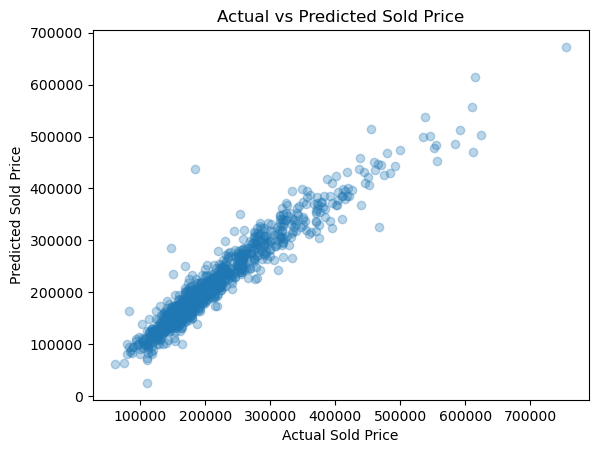

RMSE: 25516.153213144
RMSLE: 0.12249839920392153
R2: 0.9233243646278082


In [59]:

model = LinearRegression().fit(X_train, Y_train)

# fix the splits for cross validation
kf = KFold(n_splits=5, random_state=33, shuffle=True)
# shuffle = true because random_state is set, otherwise error is thrown
cv_scores = cross_val_score(model, X_train, Y_train, cv=kf)
print('Mean CV score', np.mean(cv_scores))

Y_pred = model.predict(X_train)
plot_Yt_Yp(Y_train, Y_pred)
print_errors(Y_train, Y_pred)

**NOTE**: Mean CV score is -ve infinity, which means that the model is overfitting the training data. But the model score on the train data itself is 0.92, which the model is too complex and overfits the data.

#### Testing the LR model on test dataset (without modifications)

We now test the model on the test dataset. We observe that the model performs poorly on the test dataset, with a negative R2 score and a high RMSE value. This is because the model is overfitting the training data, and hence does not generalise well on the test data.

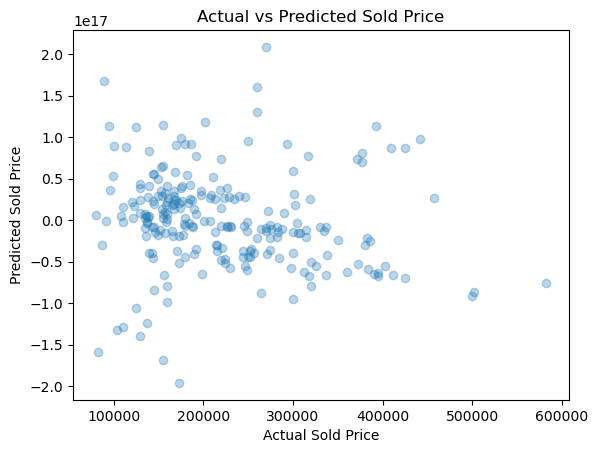

RMSE: 5.737726521794018e+16
RMSLE: cannot be calculated
R2: -4.0188335422729213e+23


In [60]:
# fit a linear regression model to the data
Y_pred= model.predict(X_test)
plot_Yt_Yp(Y_test, Y_pred)
print_errors(Y_test, Y_pred)
# negative predictions for sold price!

Above experiments confirm overfitting of the model. So we now have to do regularization to avoid overfitting.

#### 4. Add a regularization term.

- Based on the data analysis conducted during step 1, choose one of the regularization strategies we
have seen during the class. Justify your choice.
- Study the sensitivity of the regression model to the regularization hyperparameter.
- Comment on the explanatory variables.


Given that test data is unseen, we cannot use it to finetune our regularisation hyperparameter. So we rely on cross validation scores to choose the best regularisation hyperparameter. We will use 5-fold cross validation.

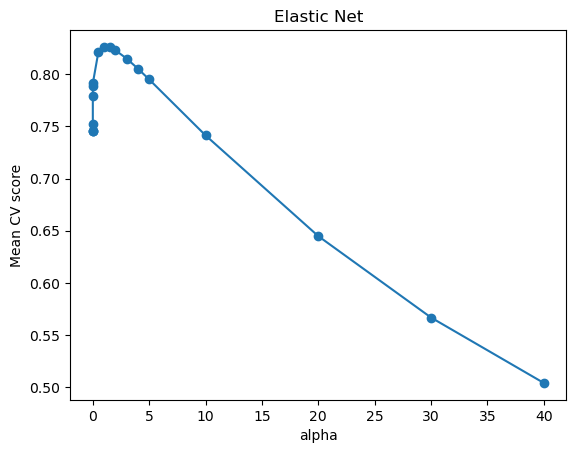

In [70]:
from sklearn.linear_model import ElasticNet

alpha_elast = [1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
mean_cv = []

# to fix the splits for cross validation
kf = KFold(n_splits=5, random_state=33, shuffle=True)

for i in alpha_elast:
    # Set up each model. 
    
    warnings.filterwarnings('ignore') #ignore warnings
    lasso_reg = ElasticNet(alpha= i, random_state=33)
    # fit the model. 
    lasso_reg.fit(X_train, Y_train)

    # Perform cross validation on the same splits each time
    cv_scores = cross_val_score(lasso_reg, X_train, Y_train, cv=kf)
    mean_cv.append(np.mean(cv_scores))

plt.plot(alpha_elast, mean_cv)
plt.scatter(alpha_elast, mean_cv)
plt.xlabel('alpha')
plt.ylabel('Mean CV score')
plt.title('Elastic Net')
plt.show() 


So alpha value of 1e-2 seems to give a good cross val score. We can use this now to train the model and test it on the test dataset.

#### 5. Evaluate the test performance of the regression models 

and determine the configuration of the best model (based on the main evaluation metric you selected in step 1).

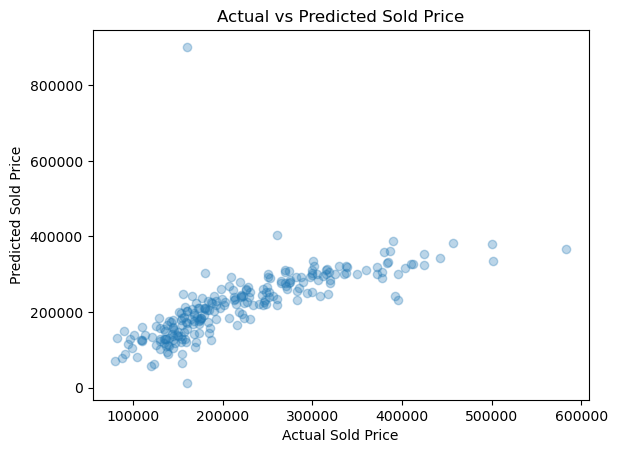

RMSE: 67375.8285542531
RMSLE: 0.29238551744800917
R2: 0.4458484310663984


In [77]:
lasso_reg = ElasticNet(alpha= 1e-2, random_state=33)
# fit the model. 
lasso_reg.fit(X_train, Y_train)

Y_pred = lasso_reg.predict(X_test)
plot_Yt_Yp(Y_test, Y_pred)
print_errors(Y_test, Y_pred)

### references

https://code.likeagirl.io/good-train-test-split-an-approach-to-better-accuracy-91427584b614